<a href="https://colab.research.google.com/github/Anikate-De/TensorFlow-Deep-Learning/blob/main/Convolutional%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision & Convolutional Neural Network

## What is Computer Vision

It refers to the practice of writing algorithms that can discover the patterns in visual data.

## What is a Convolutional Neural Network

A CNN (frequently used in this notebook) is a special kind of Neural Network that is built as a stack of Convolutional Layers and Pooling Layers. It specialises in classifying input into categories.

Convolutional Layer is the foundational unit of a CNN. The main difference between it and a Dense layer is that it forces the input values to share parameters and lets it use fewer parameters for training.

A Pooling Layer basically filters the data based on the weights, as in, only weights of considerable importance are allowed to pass through.

## Downloading our Dataset

In [4]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded data
zip = zipfile.ZipFile('pizza_steak.zip')
zip.extractall()
zip.close()


--2023-03-22 01:23:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  23.7MB/s    in 5.5s    

2023-03-22 01:23:11 (19.1 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the Data

Let's visualize the dataset to decide a way to write algorithms

In [5]:
!ls pizza_steak/train/pizza

1008104.jpg  1638227.jpg  2235981.jpg  2774899.jpg  3464027.jpg  576236.jpg
1008144.jpg  1646974.jpg  2236914.jpg  2775763.jpg  3464858.jpg  5764.jpg
1008844.jpg  1649108.jpg  2241448.jpg  2778214.jpg  3473991.jpg  579691.jpg
1008941.jpg  1649276.jpg  2247711.jpg  277963.jpg   3475936.jpg  593400.jpg
1011404.jpg  1652943.jpg  2253670.jpg  2785084.jpg  3478964.jpg  59445.jpg
102037.jpg   1654444.jpg  2255361.jpg  2793535.jpg  3479875.jpg  596494.jpg
1026922.jpg  1660415.jpg  2274117.jpg  27963.jpg    3479936.jpg  598381.jpg
1029698.jpg  1663749.jpg  2279642.jpg  2800325.jpg  3484590.jpg  604977.jpg
1033251.jpg  1665654.jpg  2280345.jpg  2811032.jpg  3493457.jpg  608085.jpg
1035854.jpg  166823.jpg   2285269.jpg  282013.jpg   349946.jpg	 618021.jpg
1038357.jpg  1670471.jpg  2285942.jpg  2821034.jpg  350358.jpg	 61822.jpg
1040878.jpg  1671531.jpg  228778.jpg   2821048.jpg  3505182.jpg  618348.jpg
1044524.jpg  1678284.jpg  2291093.jpg  2827938.jpg  3512070.jpg  625687.jpg
1044789.jpg  16810

In [6]:
# Let's list the number of files we would be working with

import os

for dirpath, dirnames, filenames in os.walk('pizza_steak'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files inside {dirpath}')

There are 2 directories and 0 files inside pizza_steak
There are 2 directories and 0 files inside pizza_steak/test
There are 0 directories and 250 files inside pizza_steak/test/steak
There are 0 directories and 250 files inside pizza_steak/test/pizza
There are 2 directories and 0 files inside pizza_steak/train
There are 0 directories and 750 files inside pizza_steak/train/steak
There are 0 directories and 750 files inside pizza_steak/train/pizza


In [7]:
# Get the class names programmatically (helpful for larger datasets)
import pathlib
import numpy as np
data_directory = pathlib.Path('pizza_steak/train')
class_names = np.array(sorted(item.name for item in data_directory.glob('*')))
print(class_names)

['pizza' 'steak']


In [8]:
# Now let's visualize the images that we have

import matplotlib.pyplot as plt
import matplotlib.image as mpimp
import random

# Create a function to show random images
def view_random_images(target_dir, target_class, num_images = 1):
  target_folder = target_dir + target_class

  if (num_images > 10):
    print('A maximum of 10 images is allowed')
    num_images = 10

  # Get a random image path
  random_images = random.sample(os.listdir(target_folder), num_images)

  plt.figure(figsize = (18, 6))

  for index in range(len(random_images)):
    # Read the image using MatplotLib
    img = mpimp.imread(target_folder + '/' + random_images[index])
    plt.subplot(2, 5, index + 1)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

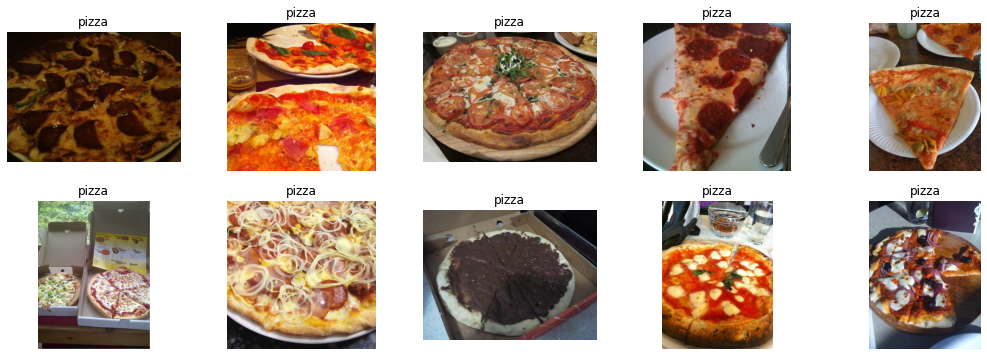

In [9]:
view_random_images(target_dir = 'pizza_steak/train/', target_class = 'pizza', num_images = 10)

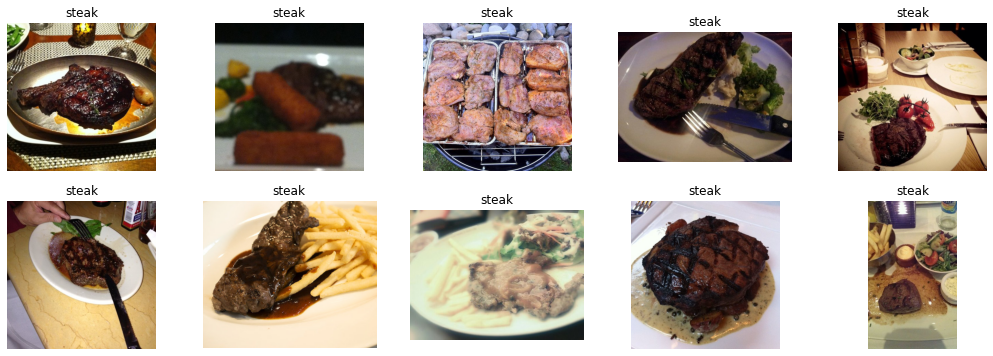

In [10]:
view_random_images(target_dir = 'pizza_steak/train/', target_class = 'steak', num_images = 10)

## Building a CNN Model

### Loading & Pre-Processing Data

We need to import data from the dataset directories. We use the `ImageDataGenerator` for this.

---

What is a *`batch`*?

A **batch** is a small subset of data that will be used at a time to train the model. A batch is created to ensure that the training of the model does not overload the system GPU, as it is comparatively much easier to read 32 images at once instead of 10,000 or so.

Why is *`batch_size = 32`*?

There are many options for setting the batch size, but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

---

*`rescale`*

The `rescale` parameter basically tells the `ImageDataGenerator` to divide the pixel values of each image by 255 so that the values get normalized `between 0 and 1`.

---

*`target_size`*

It defines the size of the images in `(height, width)`


In [11]:
# Step 1: Load & Pre-Process Images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(4)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Import data and turn it into batches
train_data = train_datagen.flow_from_directory('pizza_steak/train',
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'binary',
                                               seed = 4)
test_data = test_datagen.flow_from_directory('pizza_steak/test',
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'binary',
                                               seed = 4)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Building the Model

`Conv2D layer`

The "2D" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.

 - filters - these are the number of "feature extractors" that will be moving over our images.

 - kernel_size - the size of our filters, for example, a kernel_size of (3, 3) (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.

 - stride - the number of pixels a filter will move across as it covers the image. A stride of 1 means the filter moves across each pixel 1 by 1. A stride of 2 means it moves 2 pixels at a time.

 - padding - this can be either 'same' or 'valid', 'same' adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as 'valid' (default) cuts off excess pixels where the filter doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

---

What's a **"feature"**?

A feature can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these features are not defined by us, instead, the model learns them as it applies different filters across the image.

---

`MaxPool2D`



In [12]:
# Step 2: Build the Model

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           strides = 1,
                           activation = 'relu',
                           input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = 'valid'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 24s 233ms/step - loss: 0.6692 - accuracy: 0.6020 - val_loss: 0.5657 - val_accuracy: 0.7860
Epoch 2/5
47/47 [==============================] - 10s 207ms/step - loss: 0.5016 - accuracy: 0.7740 - val_loss: 0.3889 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 10s 218ms/step - loss: 0.4316 - accuracy: 0.8100 - val_loss: 0.3764 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 12s 256ms/step - loss: 0.4228 - accuracy: 0.8140 - val_loss: 0.3958 - val_accuracy: 0.8460
Epoch 5/5
47/47 [==============================] - 12s 254ms/step - loss: 0.3956 - accuracy: 0.8393 - val_loss: 0.4544 - val_accuracy: 0.7900


## Evaluating the Model

Let's first build a simple `Dense` layer model to compare our CNN Model

In [13]:
import tensorflow as tf

tf.random.set_seed(4)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 11s 187ms/step - loss: 3.7513 - accuracy: 0.6280 - val_loss: 0.7358 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 10s 206ms/step - loss: 1.0140 - accuracy: 0.6913 - val_loss: 0.9651 - val_accuracy: 0.6580
Epoch 3/5
47/47 [==============================] - 10s 204ms/step - loss: 0.6624 - accuracy: 0.7380 - val_loss: 0.4907 - val_accuracy: 0.7680
Epoch 4/5
47/47 [==============================] - 12s 261ms/step - loss: 0.7400 - accuracy: 0.7267 - val_loss: 0.6430 - val_accuracy: 0.7400
Epoch 5/5
47/47 [==============================] - 10s 205ms/step - loss: 0.6500 - accuracy: 0.7480 - val_loss: 0.7045 - val_accuracy: 0.7280


In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 10)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 10)       0

In [15]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 100)               15052900  
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Despite having **`500x`** more paramaters in it, `model_2` still performs worse than our CNN Model.

<Axes: >

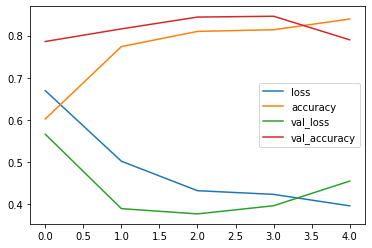

In [16]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

## Building a model with Augmented Data

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

In [17]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [18]:
train_data_augmented = train_datagen_augmented.flow_from_directory('pizza_steak/train',
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False)

train_data = train_datagen.flow_from_directory('pizza_steak/train',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

test_data = test_datagen.flow_from_directory('pizza_steak/test',
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [19]:
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

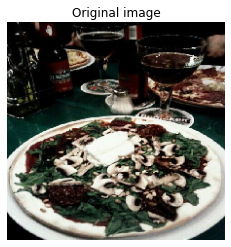

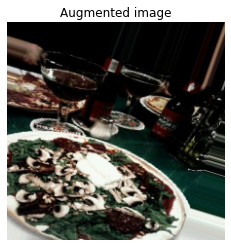

In [20]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the ImageDataGenerator class and think about how a model in your use case might benefit from some data augmentation.

In [21]:
tf.random.set_seed(4)

model_3 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  tf.keras.layers.MaxPool2D(pool_size = 2),
  tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the model
model_3.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_3 = model_3.fit(train_data_augmented, # changed to augmented training data
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps = len(test_data))
     

Epoch 1/5
47/47 [==============================] - 26s 523ms/step - loss: 0.7162 - accuracy: 0.4313 - val_loss: 0.6891 - val_accuracy: 0.5760
Epoch 2/5
47/47 [==============================] - 25s 523ms/step - loss: 0.6904 - accuracy: 0.5140 - val_loss: 0.6730 - val_accuracy: 0.7600
Epoch 3/5
47/47 [==============================] - 24s 520ms/step - loss: 0.7132 - accuracy: 0.5440 - val_loss: 0.6580 - val_accuracy: 0.7920
Epoch 4/5
47/47 [==============================] - 24s 521ms/step - loss: 0.6778 - accuracy: 0.6207 - val_loss: 0.6309 - val_accuracy: 0.7620
Epoch 5/5
47/47 [==============================] - 24s 516ms/step - loss: 0.6779 - accuracy: 0.5340 - val_loss: 0.6418 - val_accuracy: 0.7100


Each epoch taking longer when training with augmented data compared to when training with non-augmented data (~25s per epoch vs. ~10s per epoch).

This is because the `ImageDataGenerator` instance augments the data as it's loaded into the model. The benefit of this is that it leaves the original images unchanged. The downside is that it takes longer to load them in.

<Axes: >

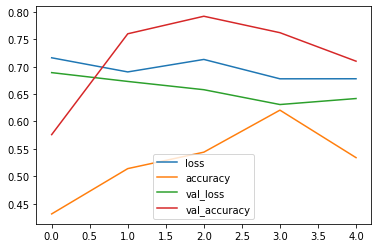

In [22]:
pd.DataFrame(history_3.history).plot()

In [23]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory('pizza_steak/train',
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [24]:
tf.random.set_seed(4)

model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  tf.keras.layers.MaxPool2D(pool_size = 2),
  tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the model
model_4.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_4 = model_4.fit(train_data_augmented_shuffled, # changed to augmented training data
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented_shuffled),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 25s 503ms/step - loss: 0.6723 - accuracy: 0.5987 - val_loss: 0.5824 - val_accuracy: 0.7140
Epoch 2/5
47/47 [==============================] - 23s 482ms/step - loss: 0.5691 - accuracy: 0.7213 - val_loss: 0.4373 - val_accuracy: 0.8180
Epoch 3/5
47/47 [==============================] - 23s 489ms/step - loss: 0.4912 - accuracy: 0.7733 - val_loss: 0.4383 - val_accuracy: 0.7980
Epoch 4/5
47/47 [==============================] - 23s 499ms/step - loss: 0.4539 - accuracy: 0.7947 - val_loss: 0.3482 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 23s 497ms/step - loss: 0.4594 - accuracy: 0.7873 - val_loss: 0.3202 - val_accuracy: 0.8800


<Axes: >

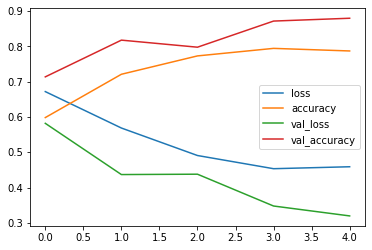

In [25]:
pd.DataFrame(history_4.history).plot()

## Predicting & Visualising Predictions

In [26]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [27]:
pred = model_4.predict(tf.expand_dims(load_and_prep_image('pizza_steak/test/pizza/1180001.jpg'), axis = 0))
pred

1/1 [==============================] - 0s 168ms/step


array([[0.3342657]], dtype=float32)

In [28]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [29]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'pizza'

In [30]:

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0), verbose = 0)

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class.title()}")
  plt.axis(False);

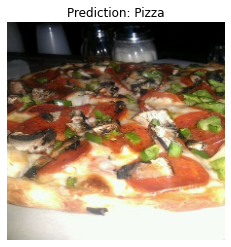

In [31]:
# Test our model on a custom image
pred_and_plot(model_4, 'pizza_steak/test/pizza/1180001.jpg', class_names)

## Multi-Class Classfication

Import the Data

In [32]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-03-22 01:58:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  24.3MB/s    in 22s     

2023-03-22 01:58:53 (22.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



Check to see the imported data structure

In [33]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [34]:
# Save Training and Testing Directories to variables
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [35]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
     

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Show random image from a class

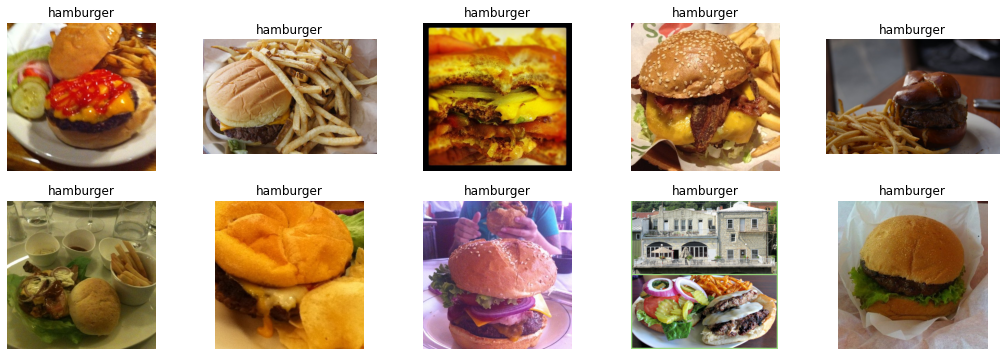

In [36]:
# View a random image from the training dataset
import random
view_random_images(target_dir=train_dir,
                        target_class=random.choice(class_names),
                   num_images = 10)

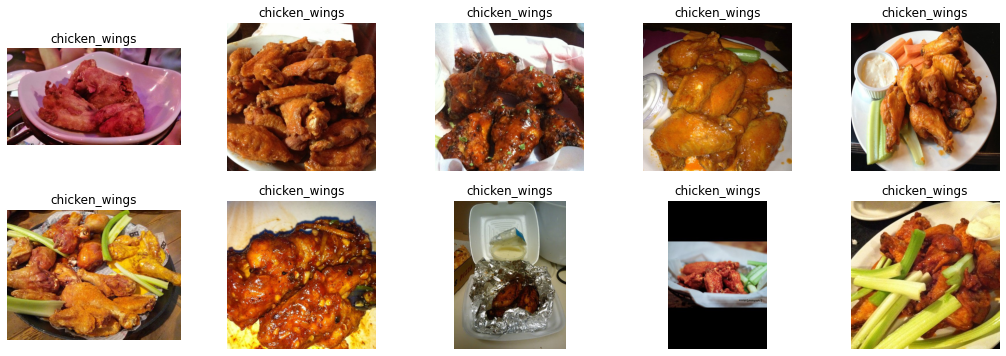

In [37]:
view_random_images(target_dir=train_dir,
                        target_class=random.choice(class_names),
                   num_images = 10)

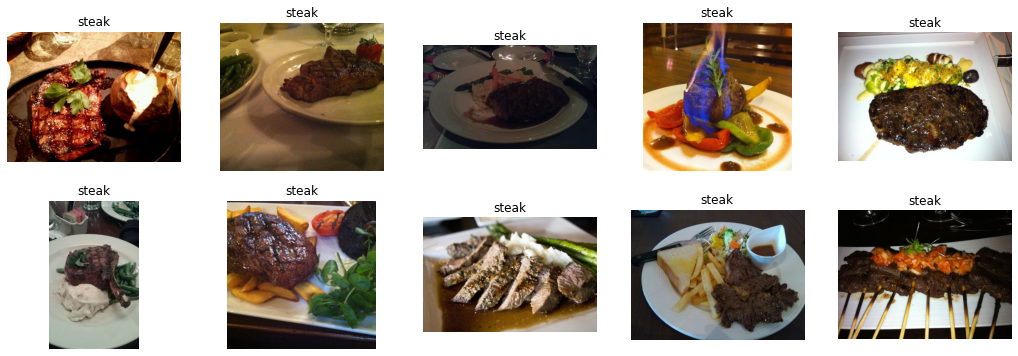

In [38]:
view_random_images(target_dir=train_dir,
                        target_class=random.choice(class_names),
                   num_images = 10)

Pre-Process Data and prepare it for the model

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [40]:

import tensorflow as tf

# Create our model (a clone of model_4, except to be multi-class)
model_5 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_5.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     

In [41]:
# Fit the model
history_5 = model_5.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 52s 210ms/step - loss: 2.3042 - accuracy: 0.1429 - val_loss: 2.1446 - val_accuracy: 0.1932
Epoch 2/5
235/235 [==============================] - 49s 210ms/step - loss: 2.0205 - accuracy: 0.2800 - val_loss: 2.0307 - val_accuracy: 0.2776
Epoch 3/5
235/235 [==============================] - 49s 209ms/step - loss: 1.6642 - accuracy: 0.4277 - val_loss: 1.9777 - val_accuracy: 0.3196
Epoch 4/5
235/235 [==============================] - 49s 209ms/step - loss: 1.1521 - accuracy: 0.6165 - val_loss: 2.4537 - val_accuracy: 0.2792
Epoch 5/5
235/235 [==============================] - 58s 246ms/step - loss: 0.5604 - accuracy: 0.8169 - val_loss: 3.1409 - val_accuracy: 0.2652


In [42]:
model_5.evaluate(test_data)

79/79 [==============================] - 12s 150ms/step - loss: 3.1409 - accuracy: 0.2652


[3.140937089920044, 0.2651999890804291]

<Axes: >

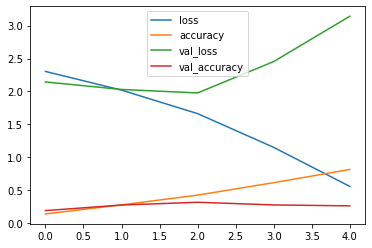

In [43]:
pd.DataFrame(history_5.history).plot()

In [44]:
import tensorflow as tf

tf.random.set_seed(4)

# Create our model (a clone of model_4, except to be multi-class)
model_6 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_6.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     
history_6 = model_6.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 50s 207ms/step - loss: 2.1572 - accuracy: 0.2383 - val_loss: 1.9709 - val_accuracy: 0.2928
Epoch 2/5
235/235 [==============================] - 47s 202ms/step - loss: 1.8114 - accuracy: 0.3763 - val_loss: 1.9112 - val_accuracy: 0.3280
Epoch 3/5
235/235 [==============================] - 47s 200ms/step - loss: 1.5398 - accuracy: 0.4864 - val_loss: 1.9262 - val_accuracy: 0.3508
Epoch 4/5
235/235 [==============================] - 56s 239ms/step - loss: 1.1317 - accuracy: 0.6365 - val_loss: 2.1077 - val_accuracy: 0.3224
Epoch 5/5
235/235 [==============================] - 47s 202ms/step - loss: 0.7008 - accuracy: 0.7933 - val_loss: 2.4207 - val_accuracy: 0.3088


<Axes: >

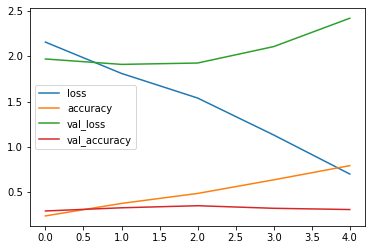

In [45]:
pd.DataFrame(history_6.history).plot()

In [46]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [48]:
# Clone the model (use the same architecture)
model_7 = tf.keras.models.clone_model(model_6)

# Compile the cloned model (same setup as used for model_10)
model_7.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_7 = model_7.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))
     

Epoch 1/5
235/235 [==============================] - 132s 558ms/step - loss: 2.1586 - accuracy: 0.2140 - val_loss: 2.0085 - val_accuracy: 0.2872
Epoch 2/5
235/235 [==============================] - 116s 496ms/step - loss: 2.0402 - accuracy: 0.2809 - val_loss: 1.9122 - val_accuracy: 0.3320
Epoch 3/5
235/235 [==============================] - 118s 501ms/step - loss: 1.9916 - accuracy: 0.3068 - val_loss: 1.9078 - val_accuracy: 0.3384
Epoch 4/5
235/235 [==============================] - 117s 498ms/step - loss: 1.9682 - accuracy: 0.3161 - val_loss: 1.8346 - val_accuracy: 0.3756
Epoch 5/5
235/235 [==============================] - 119s 505ms/step - loss: 1.9362 - accuracy: 0.3284 - val_loss: 1.7554 - val_accuracy: 0.4092


In [49]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

[[0.0603775  0.04755286 0.11926187 0.03535594 0.07697684 0.40367517
  0.0740435  0.0357368  0.01908863 0.1279309 ]]


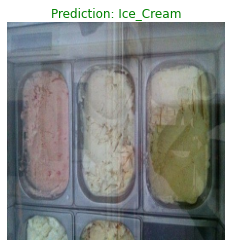

In [50]:
 # Import the target image and preprocess it
img = load_and_prep_image('10_food_classes_all_data/test/ice_cream/172466.jpg')

# Make a prediction
pred = model_7.predict(tf.expand_dims(img, axis=0), verbose = 0)

print(pred)

# Get the predicted class
pred_class = class_names[pred.argmax()]

if pred_class == 'ice_cream':
  color = 'green'
else:
  color = 'red'

# Plot the image and predicted class
plt.imshow(img)
plt.title(f"Prediction: {pred_class.title()}", fontdict = {'color': color})
plt.axis(False);

In [51]:
model_7.save("10_classes_food_classification_cnn_model")

In [52]:
model_7.save("10_classes_food_classification_cnn_model.h5")